In [139]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from gseapy import gsea
from goatools import obo_parser, go_enrichment
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy


In [140]:
# Step 2: Load and Preprocess Dataset
prostate_data = pd.read_csv('/content/drive/MyDrive/prostate_exp_cancer_preprocess.csv')

In [141]:
# Transpose the dataframe to have samples as rows and genes as columns
prostate_data = prostate_data.set_index(prostate_data.columns[0]).T

In [148]:
prostate_data

Unnamed: 0,ARHGEF10L,HIF3A,RNF10,RNF11,RNF13,GTF2IP1,REM1,RTN4RL2,C16orf13,FGFR1OP2,...,SELE,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,condition
TCGA.2A.A8VL.01,9.3347,6.6119,12.3959,11.1585,11.3048,12.6833,4.8990,5.8231,9.8040,8.3161,...,9.2531,8.7355,2.4943,8.7872,13.0567,5.9843,10.5606,7.3276,11.2719,cancer
TCGA.2A.A8VO.01,9.1050,7.1622,12.2349,10.9611,10.5777,12.6094,4.9185,5.5296,10.6038,8.4914,...,9.9090,8.3809,3.4554,8.9015,12.5682,7.1283,11.0117,8.1436,10.9057,cancer
TCGA.2A.A8VT.01,9.6582,4.6591,12.1076,11.2948,10.4915,12.5013,3.7936,6.1393,10.4041,7.9352,...,6.3555,8.4089,2.9973,8.2230,11.0394,6.8451,10.3673,7.2489,10.5206,cancer
TCGA.2A.A8VV.01,9.1667,6.6883,12.5849,10.6941,10.6701,12.7361,4.0876,5.7345,10.0141,8.3538,...,4.6440,8.5688,2.8316,8.8377,12.8527,5.5439,10.6838,7.6945,10.5403,cancer
TCGA.2A.A8VX.01,9.0166,6.7988,12.4550,11.1293,11.0694,12.6353,3.0972,4.2959,11.0805,8.5521,...,7.1351,8.1491,2.0083,8.8054,11.9106,4.4368,9.9491,4.8435,11.0117,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.ZG.A9MC.01,10.2321,4.3937,12.1044,11.1729,10.7766,13.4701,5.4608,5.3764,9.2671,8.6879,...,9.3211,8.8162,5.3413,9.3222,12.9678,7.7122,11.1051,8.7036,9.8359,cancer
TCGA.ZG.A9N3.01,8.7182,6.3421,12.4196,11.1694,10.3114,13.2772,3.8435,3.0340,10.2373,8.3652,...,9.0886,9.5033,3.2045,9.1809,12.3132,6.2672,10.0204,7.5305,9.8283,cancer
TCGA.ZG.A9ND.01,9.6963,3.5078,12.3949,11.5195,10.4051,12.8505,4.9093,6.0448,9.9126,8.4524,...,8.6417,9.1619,2.9849,8.5700,11.2957,7.1367,10.7352,6.7941,11.2749,cancer
TCGA.ZG.A9NI.01,9.5352,7.7494,12.2275,11.2784,10.7717,13.1225,6.7809,3.4289,10.8186,8.2184,...,10.6352,9.5103,3.3245,8.9701,13.7796,8.4654,11.4272,8.1890,10.9150,cancer


In [147]:
def get_condition_from_tcga_barcode(barcode):
    """
    Determine if a TCGA sample is cancer or normal based on its barcode.

    TCGA barcode format: TCGA-TSS-PARTICIPANT-SAMPLE-PORTION-ANALYTE-PLATE-CENTER
    where SAMPLE (e.g., '01A') contains sample type code ('01') that indicates tumor or normal.
    """
    # Tumor sample codes (01-09 series are tumors)
    tumor_codes = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
    # Normal sample codes (10-19 series are normal samples)
    normal_codes = ['10', '11', '12', '13', '14']

    # Get sample type code from barcode
    if '-' in barcode:
        parts = barcode.split('-')
        if len(parts) >= 4:
            sample_code = parts[3][:2]  # First two characters of the 4th hyphen-separated part
    else:
        # Handle dot-separated format if your barcodes use that format
        parts = barcode.split('.')
        if len(parts) >= 4:
            sample_code = parts[3][:2]
        else:
            sample_code = ''

    # Classify based on sample code
    if sample_code in tumor_codes:
        return 'cancer'
    elif sample_code in normal_codes:
        return 'normal'
    else:
        return 'unknown'  # For other sample types

# Apply the function to create the condition column
prostate_data['condition'] = prostate_data.index.map(get_condition_from_tcga_barcode)

# Check the distribution of sample types
print("Sample condition distribution:")
print(prostate_data['condition'].value_counts())

# Verify a few examples
print("\nSample barcode classifications:")
for barcode in prostate_data.index[:5]:
    print(f"{barcode}: {get_condition_from_tcga_barcode(barcode)}")



Sample condition distribution:
condition
cancer    498
Name: count, dtype: int64

Sample barcode classifications:
TCGA.2A.A8VL.01: cancer
TCGA.2A.A8VO.01: cancer
TCGA.2A.A8VT.01: cancer
TCGA.2A.A8VV.01: cancer
TCGA.2A.A8VX.01: cancer


In [149]:
# Check if any sample might be normal based on the sample type code
all_sample_types = [barcode.split('.')[3][:2] for barcode in prostate_data.index]
print(set(all_sample_types))


{'06', '01'}


In [150]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from scipy import stats
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.multitest import multipletests
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

Dataset dimensions: (498, 16278)
Filtered from 16278 to 14650 genes


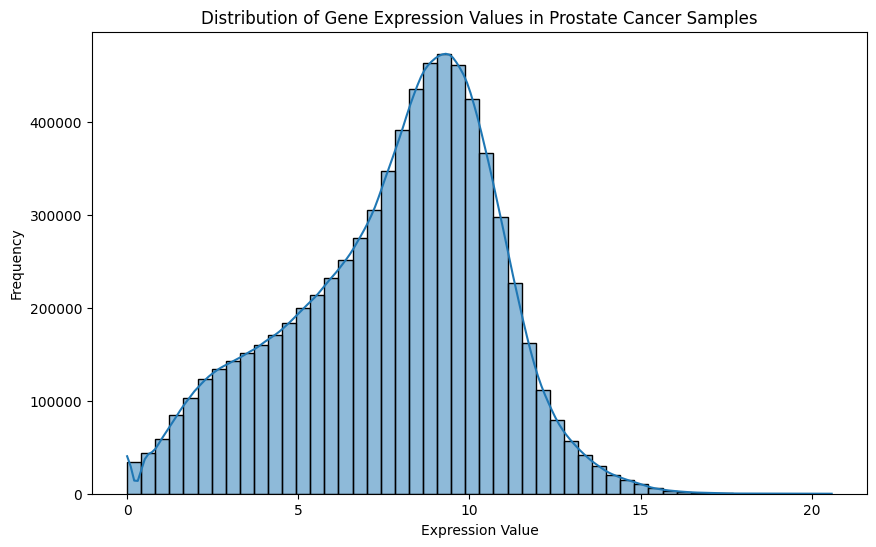

In [151]:
# Step 1: Exploratory Data Analysis for Tumor-Only Dataset

# Extract expression data
gene_expression = prostate_data.drop('condition', axis=1)
print(f"Dataset dimensions: {gene_expression.shape}")

# Filter genes with low expression or low variance
def filter_low_expression_genes(expression_data, min_expression=1, min_variance_percentile=10):
    """Filter out genes with low expression or low variance across samples."""
    # Calculate mean expression and variance for each gene
    gene_mean = expression_data.mean(axis=0)
    gene_var = expression_data.var(axis=0)

    # Filter genes based on mean expression
    high_expression_genes = gene_mean[gene_mean > min_expression].index.tolist()

    # Filter genes based on variance
    variance_threshold = np.percentile(gene_var, min_variance_percentile)
    high_variance_genes = gene_var[gene_var > variance_threshold].index.tolist()

    # Get intersection of both filters
    filtered_genes = list(set(high_expression_genes) & set(high_variance_genes))

    print(f"Filtered from {expression_data.shape[1]} to {len(filtered_genes)} genes")

    return expression_data[filtered_genes]

# Apply filtering
filtered_expression = filter_low_expression_genes(gene_expression)

# Visualize expression distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_expression.values.flatten(), bins=50, kde=True)
plt.title('Distribution of Gene Expression Values in Prostate Cancer Samples')
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.savefig('expression_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

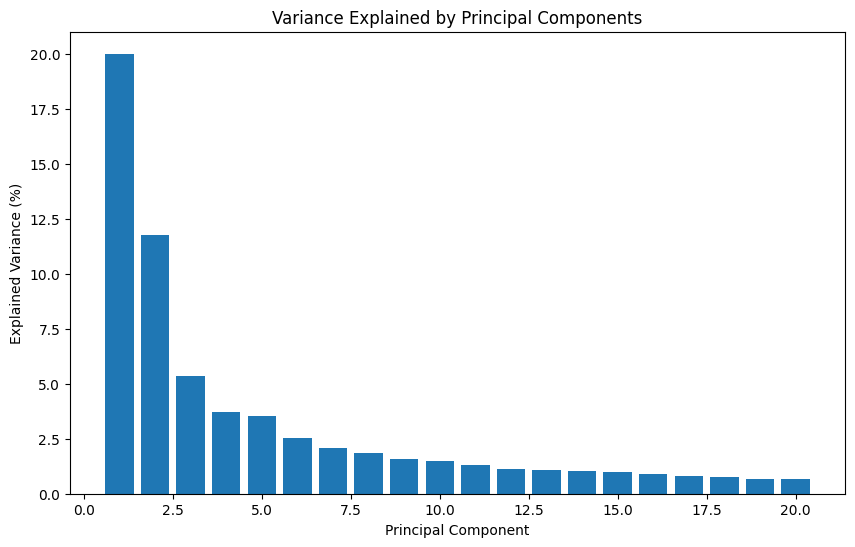

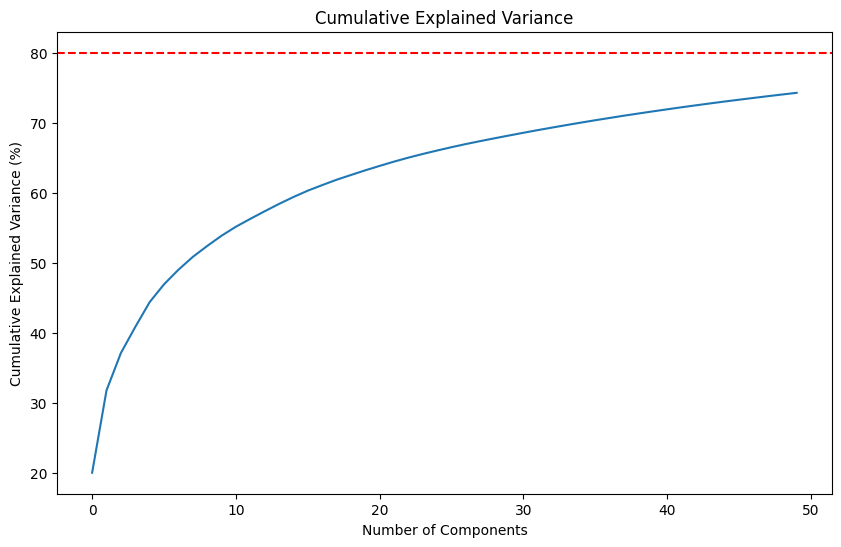

For n_clusters = 2, the silhouette score is 0.28432976829620604
For n_clusters = 3, the silhouette score is 0.17033897082984542
For n_clusters = 4, the silhouette score is 0.1657726770079099
For n_clusters = 5, the silhouette score is 0.14291712993941025
For n_clusters = 6, the silhouette score is 0.1297239052275779
For n_clusters = 7, the silhouette score is 0.12470688100578815
For n_clusters = 8, the silhouette score is 0.1273062537297054
For n_clusters = 9, the silhouette score is 0.12814953240478058


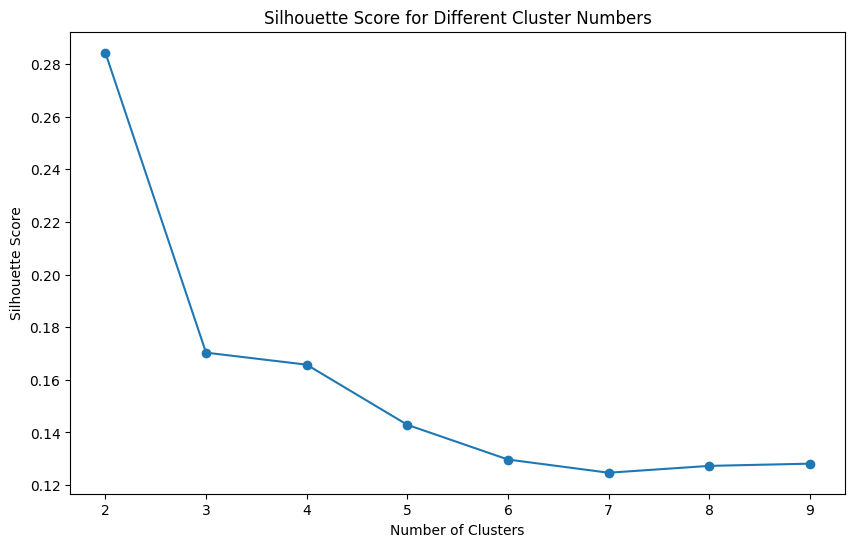

Optimal number of clusters: 2


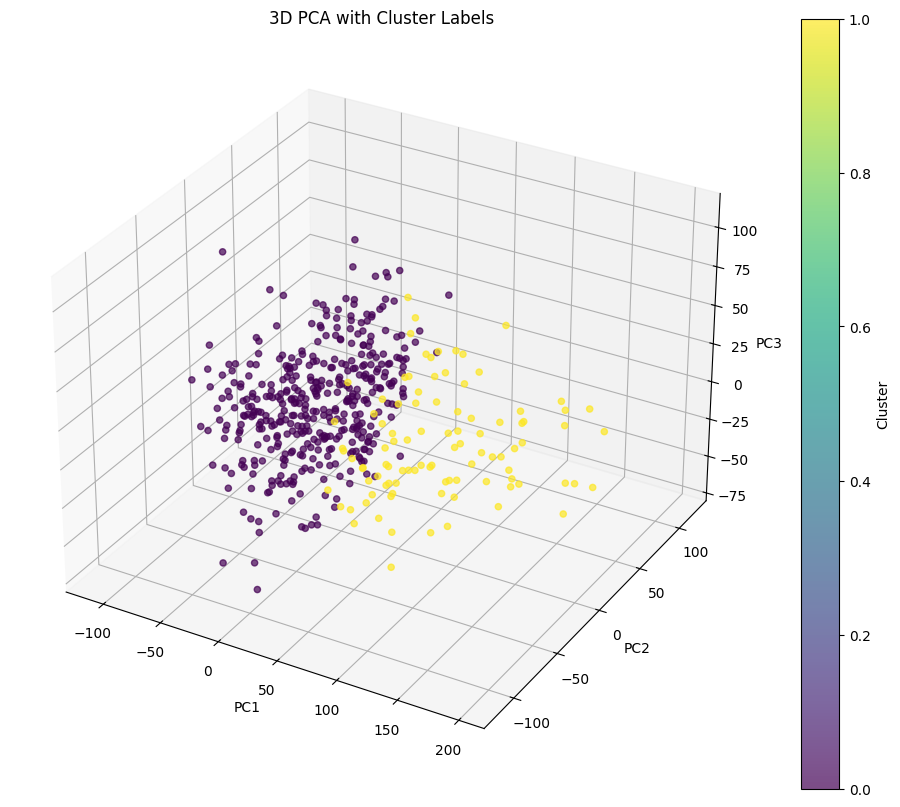

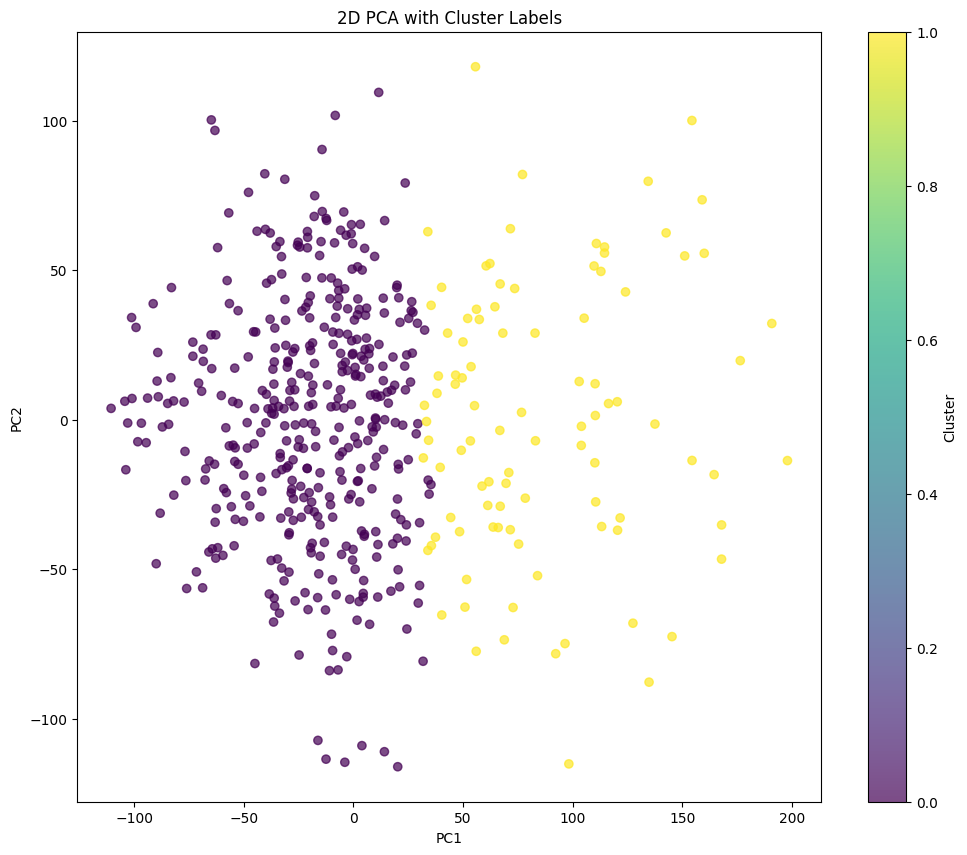

In [152]:
# Step 2: Unsupervised Analysis to Identify Potential Subtypes

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_expression)
scaled_df = pd.DataFrame(scaled_data, index=filtered_expression.index, columns=filtered_expression.columns)

# Perform PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, index=filtered_expression.index)

# Plot variance explained
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, 21), explained_variance[:20] * 100)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Variance Explained by Principal Components')
plt.savefig('pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

# Cumulative variance plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance * 100))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.axhline(y=80, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.savefig('pca_cumulative_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df.iloc[:, :10])  # Using first 10 PCs
    silhouette_avg = silhouette_score(pca_df.iloc[:, :10], cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Cluster Numbers')
plt.savefig('cluster_silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Choose optimal number of clusters based on silhouette score
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

# Perform KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df.iloc[:, :10])

# Add cluster labels to original data
prostate_data['cluster'] = cluster_labels

# Visualize clusters in PCA space (3D)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                    c=cluster_labels, cmap='viridis', alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA with Cluster Labels')
plt.colorbar(scatter, label='Cluster')
plt.savefig('pca_3d_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Create 2D PCA plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA with Cluster Labels')
plt.colorbar(scatter, label='Cluster')
plt.savefig('pca_2d_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [153]:
# Step 3: Identify Genes Characteristic of Each Cluster

def find_cluster_marker_genes(expression_data, clusters, n_top=100):
    """Find marker genes for each cluster using t-test."""
    all_clusters = sorted(set(clusters))
    cluster_markers = {}

    for cluster in all_clusters:
        # Get samples in this cluster
        cluster_samples = expression_data.index[clusters == cluster]
        other_samples = expression_data.index[clusters != cluster]

        # Initialize lists to store results
        gene_names = []
        p_values = []
        fold_changes = []

        # Perform t-test for each gene
        for gene in expression_data.columns:
            # Get expression values
            cluster_expr = expression_data.loc[cluster_samples, gene].values
            other_expr = expression_data.loc[other_samples, gene].values

            # Calculate statistics
            mean_cluster = np.mean(cluster_expr)
            mean_other = np.mean(other_expr)
            log2fc = np.log2(mean_cluster / mean_other) if mean_other > 0 else np.nan

            # Perform t-test
            t_stat, p_val = stats.ttest_ind(cluster_expr, other_expr, equal_var=False)

            # Store results
            gene_names.append(gene)
            p_values.append(p_val)
            fold_changes.append(log2fc)

        # Create results DataFrame
        results = pd.DataFrame({
            'gene': gene_names,
            'log2fc': fold_changes,
            'p_value': p_values
        })

        # Multiple testing correction
        results['padj'] = multipletests(results['p_value'], method='fdr_bh')[1]

        # Sort by significance and fold change
        results = results.sort_values(['padj', 'log2fc'], ascending=[True, False])

        # Store top markers
        cluster_markers[f'cluster_{cluster}'] = results.head(n_top)

    return cluster_markers

# Find marker genes for each cluster
cluster_markers = find_cluster_marker_genes(filtered_expression, cluster_labels)

In [154]:
# Step 4: Over-Representation Analysis for Each Cluster's Marker Genes

def run_ora_for_cluster_markers(cluster_markers, n_top=50):
    """Run ORA for top marker genes of each cluster."""
    ora_results = {}

    for cluster, markers in cluster_markers.items():
        print(f"Running ORA for {cluster}...")

        # Get top n genes ranked by significance and fold change
        top_genes = markers.head(n_top)['gene'].tolist()

        # Skip if too few genes
        if len(top_genes) < 10:
            print(f"  Too few marker genes for {cluster}, skipping")
            continue

        # Run Enrichr analysis
        cluster_ora = {}

        # Select databases for analysis
        databases = [
            'GO_Biological_Process_2021',
            'KEGG_2021_Human',
            'WikiPathways_2019_Human',
            'Reactome_2022',
            'MSigDB_Hallmark_2020'
        ]

        for db in databases:
            try:
                enrichr_results = gp.enrichr(
                    gene_list=top_genes,
                    gene_sets=db,
                    organism='Human',
                    outdir=f'./enrichr_output_{cluster}_{db}',
                    cutoff=0.05,
                    no_plot=True
                )

                # Store results
                if len(enrichr_results.results) > 0:
                    cluster_ora[db] = enrichr_results.results

                    # Plot top pathways
                    top_results = enrichr_results.results.head(15)
                    if len(top_results) > 0:
                        plt.figure(figsize=(12, 10))
                        plt.barh(top_results['Term'][::-1], -np.log10(top_results['Adjusted P-value'])[::-1])
                        plt.xlabel('-log10(Adjusted P-value)')
                        plt.title(f'Top Pathways in {db} for {cluster}')
                        plt.tight_layout()
                        plt.savefig(f'{cluster}_{db}_pathways.png', dpi=300, bbox_inches='tight')
                        plt.close()
            except Exception as e:
                print(f"  Error with {db} for {cluster}: {str(e)}")

        ora_results[cluster] = cluster_ora

    return ora_results

# Run ORA for each cluster's marker genes
cluster_ora_results = run_ora_for_cluster_markers(cluster_markers)

Running ORA for cluster_0...
Running ORA for cluster_1...


In [155]:
# Step 5: Identify Highly Expressed Genes Across All Samples

def identify_highly_expressed_genes(expression_data, percentile_threshold=90):
    """Identify genes with consistently high expression across tumor samples."""
    # Calculate mean expression for each gene
    gene_means = expression_data.mean(axis=0).sort_values(ascending=False)

    # Select top percentile of genes
    threshold = np.percentile(gene_means, 100 - percentile_threshold)
    highly_expressed = gene_means[gene_means > threshold]

    print(f"Identified {len(highly_expressed)} highly expressed genes (top {percentile_threshold}%)")

    return highly_expressed.index.tolist()

# Get highly expressed genes
highly_expressed_genes = identify_highly_expressed_genes(filtered_expression)

Identified 13185 highly expressed genes (top 90%)


In [156]:
# Step 6: Run Multiple ORA Methods on Highly Expressed Genes

def run_multiple_ora_methods(gene_list, label):
    """Run multiple ORA methods on a gene list."""
    all_results = {}

    # 1. Enrichr Analysis via GSEApy
    enrichr_results = {}
    databases = [
        'GO_Biological_Process_2021',
        'GO_Molecular_Function_2021',
        'GO_Cellular_Component_2021',
        'KEGG_2021_Human',
        'WikiPathways_2019_Human',
        'Reactome_2022',
        'MSigDB_Hallmark_2020'
    ]

    for db in databases:
        try:
            results = gp.enrichr(
                gene_list=gene_list,
                gene_sets=db,
                organism='Human',
                outdir=f'./enrichr_output_{label}_{db}',
                cutoff=0.05,
                no_plot=True
            )

            enrichr_results[db] = results.results

            # Plot top results
            if len(results.results) > 0:
                top_results = results.results.head(20)
                plt.figure(figsize=(12, 10))
                plt.barh(top_results['Term'][::-1], -np.log10(top_results['Adjusted P-value'])[::-1])
                plt.xlabel('-log10(Adjusted P-value)')
                plt.title(f'Top Enriched Terms in {db} for {label}')
                plt.tight_layout()
                plt.savefig(f'{label}_{db}_enrichment.png', dpi=300, bbox_inches='tight')
                plt.close()
        except Exception as e:
            print(f"Error running Enrichr analysis for {db}: {str(e)}")

    all_results['Enrichr'] = enrichr_results

    # 2. Custom Hypergeometric Test
    def hypergeometric_test(gene_list, pathway_genes, background_size):
        """Perform hypergeometric test for over-representation."""
        from scipy.stats import hypergeom

        # Convert to sets and get counts
        gene_set = set(gene_list)
        pathway_set = set(pathway_genes)

        overlap = len(gene_set & pathway_set)

        # Skip if no overlap
        if overlap == 0:
            return 1.0

        # Calculate hypergeometric p-value
        p_value = hypergeom.sf(
            overlap - 1,  # number of successes
            background_size,  # population size
            len(pathway_set),  # number of success states in the population
            len(gene_set)  # number of trials
        )

        return p_value

    # Run hypergeometric test on MSigDB Hallmark gene sets
    try:
        hallmark_sets = gp.get_library('MSigDB_Hallmark_2020')
        background_size = len(filtered_expression.columns)  # All genes as background

        hyper_results = []
        for pathway, genes in hallmark_sets.items():
            p_value = hypergeometric_test(gene_list, genes, background_size)

            hyper_results.append({
                'Pathway': pathway,
                'Overlap_Size': len(set(gene_list) & set(genes)),
                'Gene_List_Size': len(gene_list),
                'Pathway_Size': len(genes),
                'P_value': p_value
            })

        # Convert to DataFrame
        hyper_df = pd.DataFrame(hyper_results)

        # Multiple testing correction
        hyper_df['Adjusted_P_value'] = multipletests(hyper_df['P_value'], method='fdr_bh')[1]

        # Sort by adjusted p-value
        hyper_df = hyper_df.sort_values('Adjusted_P_value')

        # Store results
        all_results['Hypergeometric'] = hyper_df

        # Plot top results
        if len(hyper_df) > 0:
            top_hyper = hyper_df.head(20)
            plt.figure(figsize=(12, 10))
            plt.barh(top_hyper['Pathway'][::-1], -np.log10(top_hyper['Adjusted_P_value'])[::-1])
            plt.xlabel('-log10(Adjusted P-value)')
            plt.title(f'Top Pathways from Hypergeometric Test for {label}')
            plt.tight_layout()
            plt.savefig(f'{label}_hypergeometric_results.png', dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error running hypergeometric test: {str(e)}")

    # 3. Fisher's Exact Test
    def fishers_exact_test(gene_list, pathway_genes, all_genes):
        """Perform Fisher's exact test for over-representation."""
        from scipy.stats import fisher_exact

        # Convert to sets
        gene_set = set(gene_list)
        pathway_set = set(pathway_genes)
        all_genes_set = set(all_genes)

        # Create contingency table
        a = len(gene_set & pathway_set)  # Genes in both lists
        b = len(gene_set) - a  # Genes in gene_list but not in pathway
        c = len(pathway_set) - a  # Genes in pathway but not in gene_list
        d = len(all_genes_set) - a - b - c  # Genes in neither list

        # Skip if any cell is 0
        if min(a, b, c, d) < 0:
            return 1.0

        # Perform Fisher's exact test
        _, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')

        return p_value

    # Run Fisher's exact test on KEGG pathways
    try:
        kegg_sets = gp.get_library('KEGG_2021_Human')
        all_genes = filtered_expression.columns.tolist()

        fisher_results = []
        for pathway, genes in kegg_sets.items():
            p_value = fishers_exact_test(gene_list, genes, all_genes)

            fisher_results.append({
                'Pathway': pathway,
                'Overlap_Size': len(set(gene_list) & set(genes)),
                'Gene_List_Size': len(gene_list),
                'Pathway_Size': len(set(genes) & set(all_genes)),
                'P_value': p_value
            })

        # Convert to DataFrame
        fisher_df = pd.DataFrame(fisher_results)

        # Multiple testing correction
        fisher_df['Adjusted_P_value'] = multipletests(fisher_df['P_value'], method='fdr_bh')[1]

        # Sort by adjusted p-value
        fisher_df = fisher_df.sort_values('Adjusted_P_value')

        # Store results
        all_results['Fisher'] = fisher_df

        # Plot top results
        if len(fisher_df) > 0:
            top_fisher = fisher_df.head(20)
            plt.figure(figsize=(12, 10))
            plt.barh(top_fisher['Pathway'][::-1], -np.log10(top_fisher['Adjusted_P_value'])[::-1])
            plt.xlabel('-log10(Adjusted P-value)')
            plt.title(f'Top Pathways from Fisher\'s Exact Test for {label}')
            plt.tight_layout()
            plt.savefig(f'{label}_fishers_exact_results.png', dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error running Fisher's exact test: {str(e)}")

    return all_results

# Run multiple ORA methods on highly expressed genes
highly_expressed_ora = run_multiple_ora_methods(highly_expressed_genes, 'highly_expressed')


Consensus Pathways for Highly Expressed Genes:
  Cell cycle: Found in 2 method results
  Cellular senescence: Found in 2 method results
  Estrogen Response Late: Found in 2 method results
  Estrogen Response Early: Found in 2 method results
  TNF-alpha Signaling via NF-kB: Found in 2 method results
  Interferon Gamma Response: Found in 2 method results
  Mitotic Spindle: Found in 2 method results
  Hypoxia: Found in 2 method results
  Interferon Alpha Response: Found in 2 method results
  Apoptosis: Found in 2 method results
  Cholesterol Homeostasis: Found in 2 method results
  TGF-beta Signaling: Found in 2 method results
  Androgen Response: Found in 2 method results
  Adipogenesis: Found in 2 method results


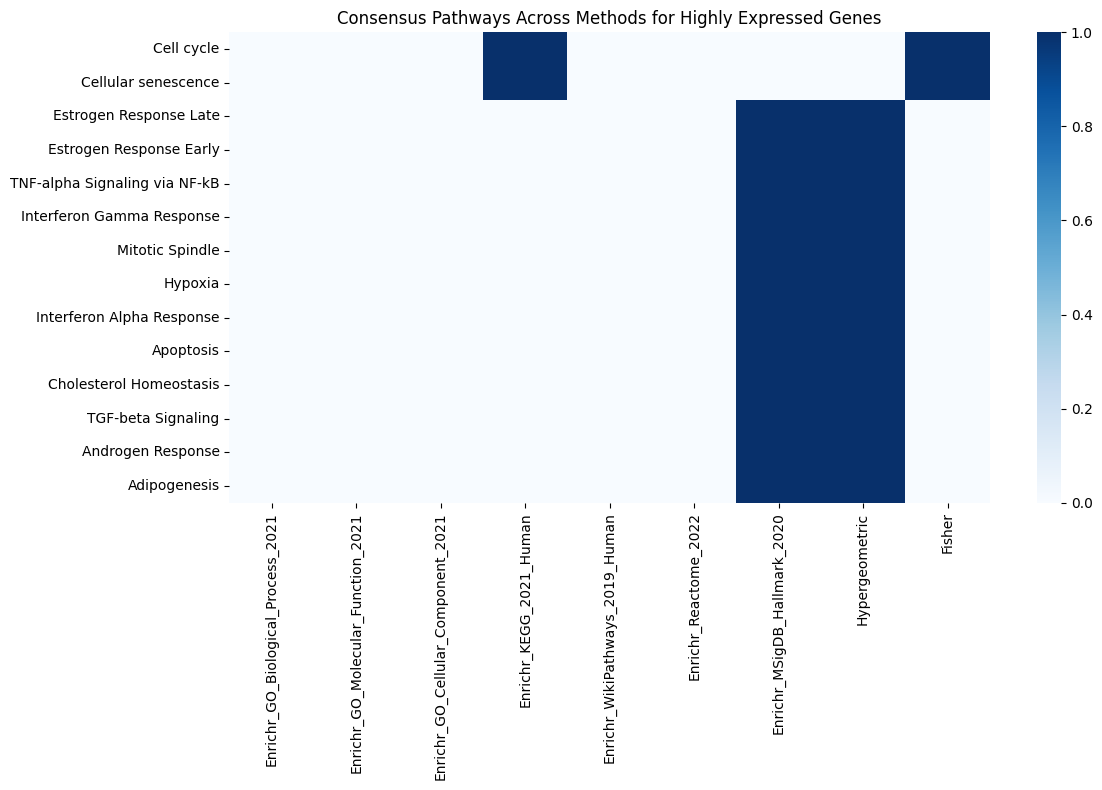

In [157]:
# Step 7: Compare Results from Different ORA Methods

def compare_ora_methods(ora_results_dict, label):
    """Compare results from different ORA methods and find consensus pathways."""
    # Extract top pathways from each method
    top_pathways = {}

    # From Enrichr results
    if 'Enrichr' in ora_results_dict:
        for db, res_df in ora_results_dict['Enrichr'].items():
            if len(res_df) > 0:
                top_pathways[f'Enrichr_{db}'] = res_df.sort_values('Adjusted P-value').head(20)['Term'].tolist()

    # From Hypergeometric test
    if 'Hypergeometric' in ora_results_dict and len(ora_results_dict['Hypergeometric']) > 0:
        top_pathways['Hypergeometric'] = ora_results_dict['Hypergeometric'].sort_values('Adjusted_P_value').head(20)['Pathway'].tolist()

    # From Fisher's exact test
    if 'Fisher' in ora_results_dict and len(ora_results_dict['Fisher']) > 0:
        top_pathways['Fisher'] = ora_results_dict['Fisher'].sort_values('Adjusted_P_value').head(20)['Pathway'].tolist()

    # Find overlapping pathways
    all_pathways = []
    for method, pathways in top_pathways.items():
        all_pathways.extend(pathways)

    # Count occurrences
    from collections import Counter
    pathway_counts = Counter(all_pathways)

    # Filter for pathways appearing in multiple methods
    overlapping = {pathway: count for pathway, count in pathway_counts.items() if count > 1}

    # Sort by occurrence count
    sorted_overlapping = dict(sorted(overlapping.items(), key=lambda x: x[1], reverse=True))

    print(f"\nConsensus Pathways for {label}:")
    for pathway, count in sorted_overlapping.items():
        print(f"  {pathway}: Found in {count} method results")

    # Create overlap matrix
    overlap_matrix = np.zeros((len(sorted_overlapping), len(top_pathways)))
    pathways_list = list(sorted_overlapping.keys())
    methods_list = list(top_pathways.keys())

    for i, pathway in enumerate(pathways_list):
        for j, method in enumerate(methods_list):
            if pathway in top_pathways[method]:
                overlap_matrix[i, j] = 1

    # Plot heatmap if there are overlapping pathways
    if len(pathways_list) > 0:
        plt.figure(figsize=(12, max(8, len(pathways_list) * 0.4)))
        sns.heatmap(overlap_matrix, xticklabels=methods_list, yticklabels=pathways_list, cmap='Blues')
        plt.title(f'Consensus Pathways Across Methods for {label}')
        plt.tight_layout()
        plt.savefig(f'{label}_consensus_pathways.png', dpi=300, bbox_inches='tight')
        plt.show()

    return sorted_overlapping, top_pathways

# Compare ORA results for highly expressed genes
highly_expressed_consensus, highly_expressed_top = compare_ora_methods(highly_expressed_ora, 'Highly Expressed Genes')

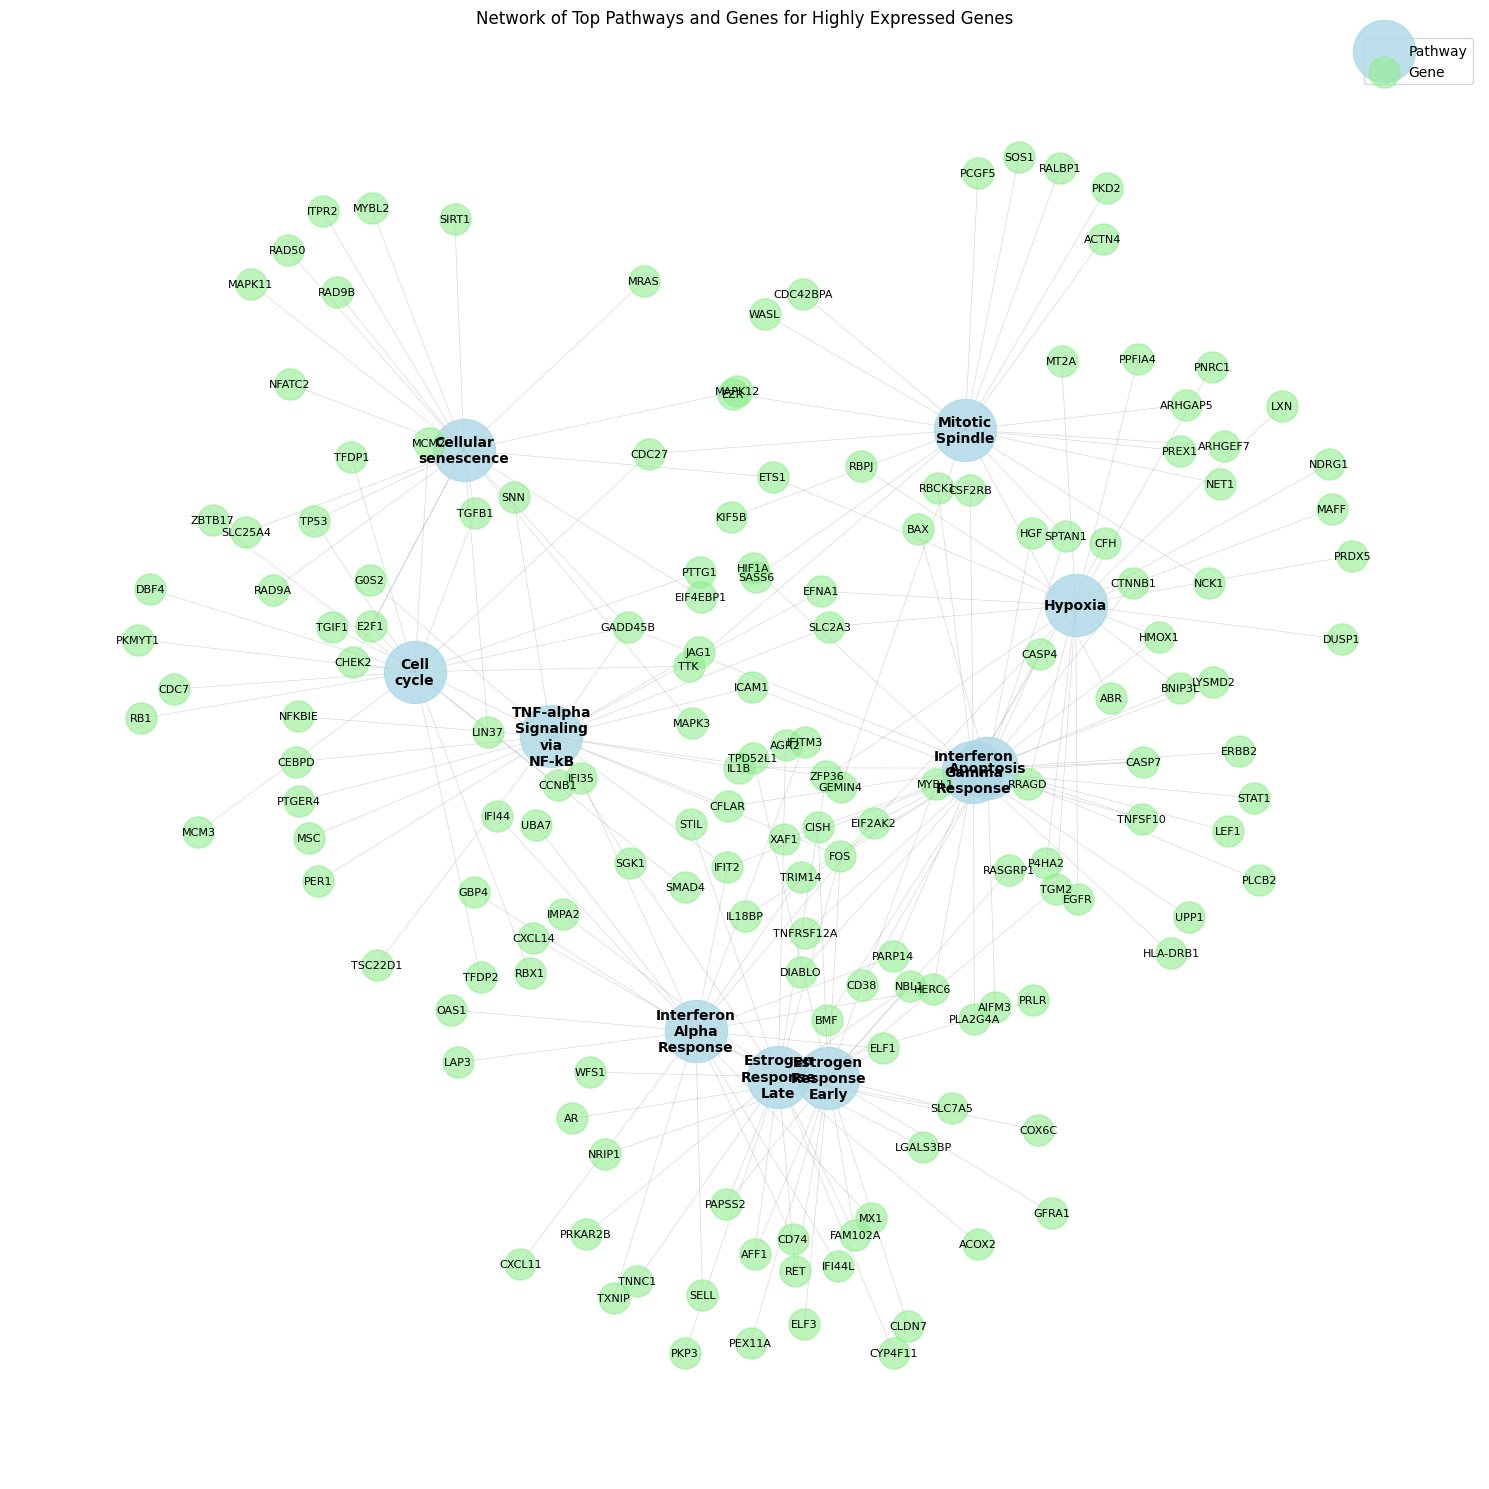

In [158]:
# Step 8: Create Network Visualization of Top Pathways and Genes

def create_pathway_gene_network(consensus_pathways, gene_list, label, max_pathways=10, max_genes_per_pathway=20):
    """Create network visualization of top pathways and their genes."""
    # Get gene sets from various databases
    gene_sets = {}
    for db in ['KEGG_2021_Human', 'GO_Biological_Process_2021', 'MSigDB_Hallmark_2020', 'Reactome_2022']:
        try:
            sets = gp.get_library(db)
            gene_sets.update(sets)
        except Exception as e:
            print(f"Error loading {db}: {str(e)}")

    # Create network
    G = nx.Graph()

    # Add top pathways and their genes
    for i, (pathway, _) in enumerate(consensus_pathways.items()):
        if i >= max_pathways:
            break

        # Skip if pathway not in gene sets
        if pathway not in gene_sets:
            continue

        # Add pathway node
        G.add_node(pathway, type='pathway')

        # Get pathway genes that are in our gene list
        pathway_genes = list(set(gene_sets[pathway]) & set(gene_list))

        # Limit to max_genes_per_pathway
        pathway_genes = pathway_genes[:max_genes_per_pathway]

        # Add gene nodes and edges
        for gene in pathway_genes:
            G.add_node(gene, type='gene')
            G.add_edge(pathway, gene, color='lightblue')

    # Check if network has edges
    if len(G.edges()) == 0:
        print(f"No pathway-gene connections found for {label} network")
        return None

    # Plot network
    plt.figure(figsize=(15, 15))

    # Define node positions using spring layout
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw nodes with different colors for pathways and genes
    pathway_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'pathway']
    gene_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'gene']

    # Draw pathway nodes (larger)
    nx.draw_networkx_nodes(G, pos, nodelist=pathway_nodes, node_size=2000,
                          node_color='lightblue', alpha=0.8, label='Pathway')

    # Draw gene nodes (smaller)
    nx.draw_networkx_nodes(G, pos, nodelist=gene_nodes, node_size=500,
                          node_color='lightgreen', alpha=0.6, label='Gene')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color='gray')

    # Add labels for pathways only
    pathway_labels = {node: '\n'.join(node.split(' ')[:4]) for node in pathway_nodes}
    nx.draw_networkx_labels(G, pos, labels=pathway_labels, font_size=10, font_weight='bold')

    # Add labels for genes (optional)
    gene_labels = {node: node for node in gene_nodes}
    nx.draw_networkx_labels(G, pos, labels=gene_labels, font_size=8)

    plt.title(f'Network of Top Pathways and Genes for {label}')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{label}_pathway_gene_network.png', dpi=300, bbox_inches='tight')
    plt.show()

    return G

# Create pathway-gene network for highly expressed genes
highly_expressed_network = create_pathway_gene_network(
    highly_expressed_consensus,
    highly_expressed_genes,
    'Highly Expressed Genes'
)


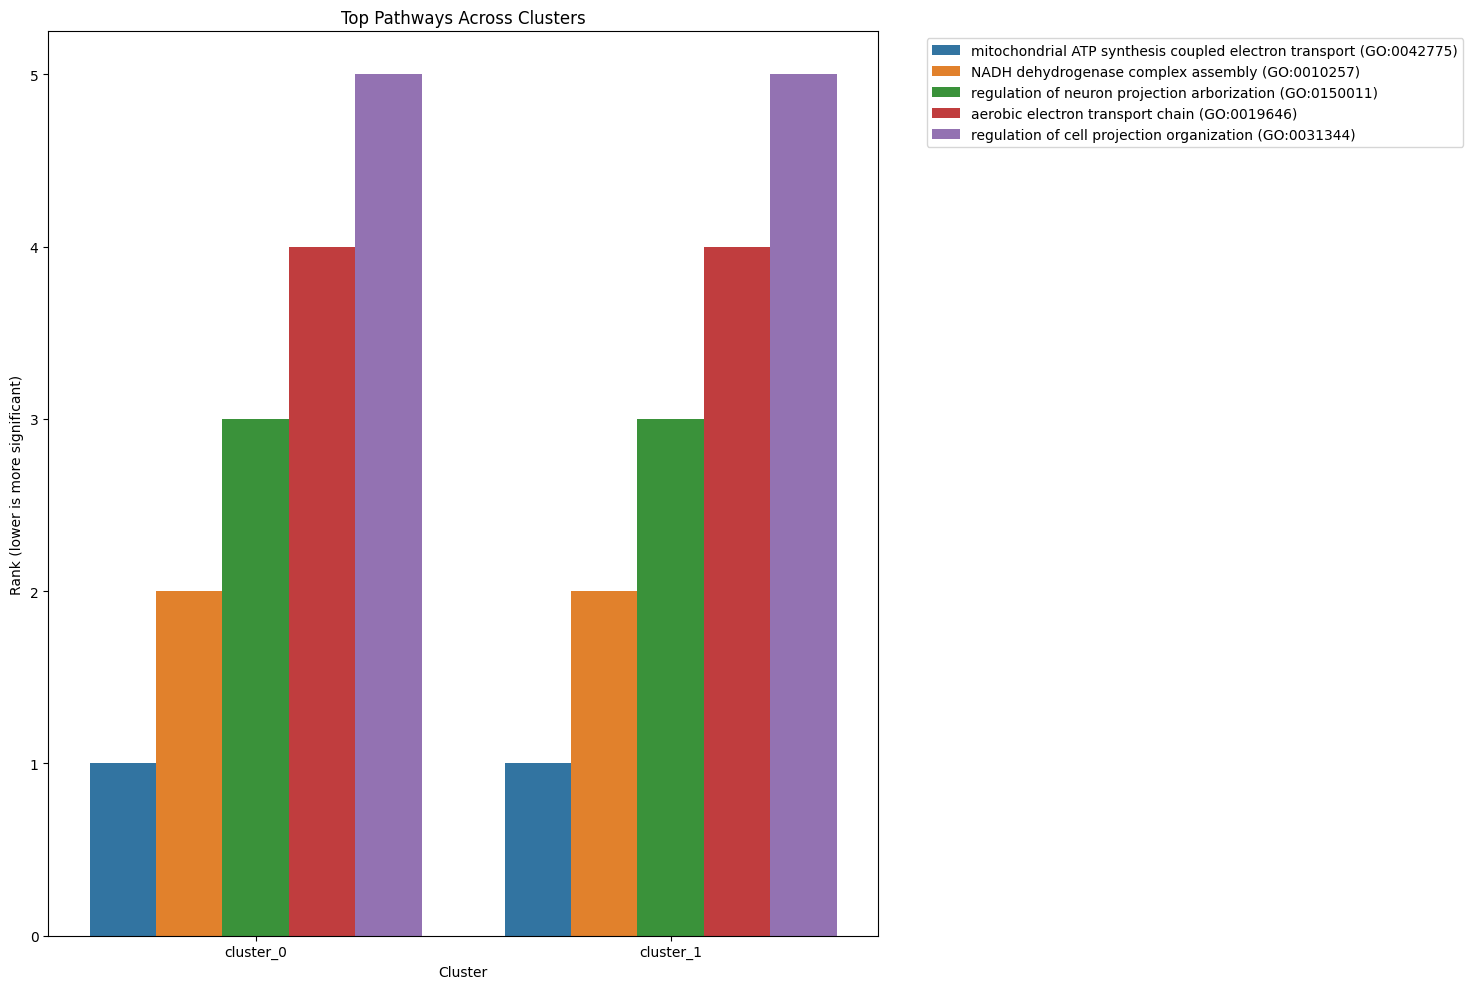

In [159]:
# Step 9: Cluster Analysis for Pathway Enrichment

# Compare pathway enrichment across clusters
def compare_cluster_enrichment(cluster_ora_results, n_top=5):
    """Compare pathway enrichment across different clusters."""
    # Collect top pathways from each cluster
    cluster_top_pathways = {}
    pathway_database = 'GO_Biological_Process_2021'  # Choose one database for comparison

    for cluster, results in cluster_ora_results.items():
        if pathway_database in results and len(results[pathway_database]) > 0:
            top_paths = results[pathway_database].sort_values('Adjusted P-value').head(n_top)['Term'].tolist()
            cluster_top_pathways[cluster] = top_paths

    # Create comparison table
    comparison_data = []
    for cluster, pathways in cluster_top_pathways.items():
        for i, pathway in enumerate(pathways):
            comparison_data.append({
                'Cluster': cluster,
                'Rank': i + 1,
                'Pathway': pathway,
                'Adjusted_P_value': cluster_ora_results[cluster][pathway_database].loc[
                    cluster_ora_results[cluster][pathway_database]['Term'] == pathway,
                    'Adjusted P-value'
                ].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)

    # Plot comparison
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Cluster', y='Rank', hue='Pathway', data=comparison_df)
    plt.title('Top Pathways Across Clusters')
    plt.ylabel('Rank (lower is more significant)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('cluster_pathway_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    return comparison_df

# Compare pathway enrichment across clusters
try:
    cluster_comparison = compare_cluster_enrichment(cluster_ora_results)
except Exception as e:
    print(f"Error comparing cluster enrichment: {str(e)}")

In [160]:
# Step 10: Generate Comprehensive Summary Report

def generate_summary_report():
    """Generate a comprehensive summary of all analyses."""
    report = []

    # Introduction
    report.append("# Comparative Over-Representation Analysis of Prostate Cancer Transcriptomes")
    report.append("\n## Project Summary")
    report.append("This analysis focused on identifying key biological pathways in prostate cancer transcriptomes through a comprehensive over-representation analysis approach. Since the dataset contained only tumor samples, we employed clustering to identify potential subtypes and analyzed pathway enrichment within these subtypes as well as across all tumor samples.")

    # Dataset Information
    report.append("\n## Dataset Information")
    report.append(f"- Total samples: {gene_expression.shape[0]}")
    report.append(f"- Total genes: {gene_expression.shape[1]}")
    report.append(f"- After filtering: {filtered_expression.shape[1]} genes retained")

    # Clustering Results
    report.append("\n## Tumor Clustering Analysis")
    report.append(f"- Optimal number of clusters identified: {optimal_clusters}")
    report.append(f"- Cluster distribution: {pd.Series(cluster_labels).value_counts().to_dict()}")
    report.append("- Principal Component Analysis revealed distinct clusters suggestive of molecular subtypes")

    # Pathway Analysis Results
    report.append("\n## Highly Expressed Genes Pathway Analysis")
    report.append(f"- Identified {len(highly_expressed_genes)} highly expressed genes across tumor samples")

    # Top Consensus Pathways
    report.append("\n### Top Consensus Pathways")
    for pathway, count in list(highly_expressed_consensus.items())[:10]:
        report.append(f"- {pathway}: Found in {count} different analysis methods")

    # Cluster-Specific Pathways
    report.append("\n## Cluster-Specific Pathway Enrichment")
    for cluster in cluster_ora_results.keys():
        report.append(f"\n### {cluster}")
        top_pathways = []
        for db in ['GO_Biological_Process_2021', 'KEGG_2021_Human']:
            if db in cluster_ora_results[cluster] and len(cluster_ora_results[cluster][db]) > 0:
                top = cluster_ora_results[cluster][db].sort_values('Adjusted P-value').head(3)['Term'].tolist()
                for path in top:
                    top_pathways.append(f"- {path} ({db})")
        for pathway in top_pathways:
            report.append(pathway)

    # Conclusion
    report.append("\n## Conclusion")
    report.append("This analysis identified key biological pathways active in prostate cancer samples. Despite the lack of normal tissue for comparison, we were able to identify potential tumor subtypes with distinct pathway signatures. The consensus pathways identified through multiple ORA methods represent robust biological signals that may guide further investigation into prostate cancer mechanisms and potential therapeutic targets.")

    # Save report
    with open('prostate_cancer_ora_report.md', 'w') as f:
        f.write('\n'.join(report))

    print("Summary report generated and saved to 'prostate_cancer_ora_report.md'")

# Generate summary report
generate_summary_report()

print("Analysis completed successfully!")

Summary report generated and saved to 'prostate_cancer_ora_report.md'
Analysis completed successfully!
